# 3-3,高阶API示范

Pytorch没有官方的高阶API，一般需要用户自己实现训练循环、验证循环、和预测循环。

作者通过仿照tf.keras.Model的功能对Pytorch的nn.Module进行了封装，设计了torchkeras.Model类，

实现了 fit, validate，predict, summary 方法，相当于用户自定义高阶API。

并示范了用它实现线性回归模型。

此外，作者还通过借用pytorch_lightning的功能，封装了类Keras接口的另外一种实现，即torchkeras.LightModel类。

并示范了用它实现DNN二分类模型。



In [1]:
import os
import datetime
from torchkeras import Model, summary

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


### 一，线性回归模型

此范例我们通过继承torchkeras.Model模型接口，实现线性回归模型。

**1，准备数据**

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动


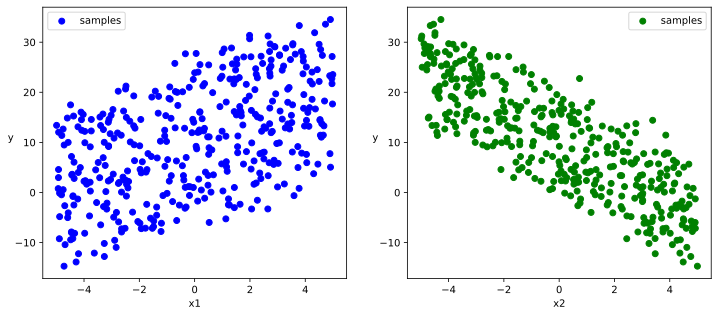

In [3]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


![](./data/3-3-回归数据可视化.png)

In [4]:
#构建输入数据管道
ds = TensorDataset(X,Y)
ds_train,ds_valid = torch.utils.data.random_split(ds,[int(400*0.7),400-int(400*0.7)])
dl_train = DataLoader(ds_train,batch_size = 10,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 10,num_workers=2)


**2，定义模型**

In [5]:
# 继承用户自定义模型
from torchkeras import Model
class LinearRegression(Model):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(2,1)
    
    def forward(self,x):
        return self.fc(x)

model = LinearRegression()


In [6]:
model.summary(input_shape = (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 1]               3
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------


```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1                    [-1, 1]               3
================================================================
Total params: 3
Trainable params: 3
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000027
----------------------------------------------------------------
```

**3，训练模型**

In [7]:
### 使用fit方法进行训练

def mean_absolute_error(y_pred,y_true):
    return torch.mean(torch.abs(y_pred-y_true))

def mean_absolute_percent_error(y_pred,y_true):
    absolute_percent_error = (torch.abs(y_pred-y_true)+1e-7)/(torch.abs(y_true)+1e-7)
    return torch.mean(absolute_percent_error)

model.compile(loss_func = nn.MSELoss(),
              optimizer= torch.optim.Adam(model.parameters(),lr = 0.01),
              metrics_dict={"mae":mean_absolute_error,"mape":mean_absolute_percent_error})

dfhistory = model.fit(200,dl_train = dl_train, dl_val = dl_valid,log_step_freq = 20)


Start Training ...

================================================================================2021-07-01 15:08:49
{'step': 20, 'loss': 218.923, 'mae': 12.36, 'mape': 1.088}

 +-------+---------+--------+-------+----------+---------+----------+
| epoch |   loss  |  mae   |  mape | val_loss | val_mae | val_mape |
+-------+---------+--------+-------+----------+---------+----------+
|   1   | 211.968 | 12.024 | 1.168 | 222.296  |  12.236 |  1.289   |
+-------+---------+--------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:49
{'step': 20, 'loss': 191.352, 'mae': 11.4, 'mape': 1.212}

 +-------+---------+--------+-------+----------+---------+----------+
| epoch |   loss  |  mae   |  mape | val_loss | val_mae | val_mape |
+-------+---------+--------+-------+----------+---------+----------+
|   2   | 189.475 | 11.418 | 1.218 | 198.144  |  11.618 |  1.395   |
+-------+---------+--------+-------+-

{'step': 20, 'loss': 46.549, 'mae': 6.401, 'mape': 1.96}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   18  | 45.321 | 6.326 | 1.695 |  45.498  |  6.232  |  2.056   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:51
{'step': 20, 'loss': 40.403, 'mae': 5.97, 'mape': 1.787}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   19  | 42.295 | 6.114 | 1.663 |  42.467  |  6.014  |  2.021   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:51
{'step': 2

{'step': 20, 'loss': 14.502, 'mae': 3.349, 'mape': 1.237}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   35  | 14.845 | 3.409 | 1.042 |  14.871  |  3.286  |  1.273   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:52
{'step': 20, 'loss': 13.95, 'mae': 3.264, 'mape': 0.752}

 +-------+--------+-------+-------+----------+---------+----------+
| epoch |  loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+--------+-------+-------+----------+---------+----------+
|   36  | 13.926 | 3.275 | 1.004 |  13.915  |  3.166  |  1.233   |
+-------+--------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:52
{'step': 

{'step': 20, 'loss': 5.883, 'mae': 1.956, 'mape': 0.674}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   52  | 6.018 | 1.949 | 0.552 |  6.498   |  2.028  |  0.708   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:53
{'step': 20, 'loss': 5.912, 'mae': 1.959, 'mape': 0.521}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   53  | 5.819 | 1.912 | 0.536 |  6.278   |  1.986  |  0.681   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:54
{'step': 20, 'loss':

{'step': 20, 'loss': 4.459, 'mae': 1.67, 'mape': 0.398}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   69  | 4.325 | 1.629 | 0.381 |  4.941   |   1.73  |  0.498   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:55
{'step': 20, 'loss': 4.235, 'mae': 1.596, 'mape': 0.366}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|   70  | 4.303 | 1.625 | 0.377 |  4.944   |  1.726  |  0.491   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:55
{'step': 20, 'loss': 

{'step': 20, 'loss': 4.131, 'mae': 1.561, 'mape': 0.355}

 +-------+-------+------+-------+----------+---------+----------+
| epoch |  loss | mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+------+-------+----------+---------+----------+
|   86  | 4.148 | 1.59 | 0.338 |  4.815   |  1.693  |  0.449   |
+-------+-------+------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:56
{'step': 20, 'loss': 4.041, 'mae': 1.581, 'mape': 0.337}

 +-------+-------+-------+------+----------+---------+----------+
| epoch |  loss |  mae  | mape | val_loss | val_mae | val_mape |
+-------+-------+-------+------+----------+---------+----------+
|   87  | 4.158 | 1.591 | 0.34 |  4.804   |  1.692  |  0.447   |
+-------+-------+-------+------+----------+---------+----------+

================================================================================2021-07-01 15:08:56
{'step': 20, 'loss': 4.093, 'm

{'step': 20, 'loss': 3.494, 'mae': 1.445, 'mape': 0.303}

 +-------+------+-------+-------+----------+---------+----------+
| epoch | loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+------+-------+-------+----------+---------+----------+
|  103  | 4.14 | 1.586 | 0.326 |  4.812   |   1.69  |  0.438   |
+-------+------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:58
{'step': 20, 'loss': 4.154, 'mae': 1.597, 'mape': 0.332}

 +-------+-------+-------+------+----------+---------+----------+
| epoch |  loss |  mae  | mape | val_loss | val_mae | val_mape |
+-------+-------+-------+------+----------+---------+----------+
|  104  | 4.145 | 1.589 | 0.33 |  4.853   |  1.696  |  0.441   |
+-------+-------+-------+------+----------+---------+----------+

================================================================================2021-07-01 15:08:58
{'step': 20, 'loss': 4.218, 'm

{'step': 20, 'loss': 3.76, 'mae': 1.526, 'mape': 0.312}

 +-------+-------+------+-------+----------+---------+----------+
| epoch |  loss | mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+------+-------+----------+---------+----------+
|  120  | 4.152 | 1.59 | 0.331 |  4.836   |  1.694  |   0.44   |
+-------+-------+------+-------+----------+---------+----------+

================================================================================2021-07-01 15:08:59
{'step': 20, 'loss': 4.174, 'mae': 1.586, 'mape': 0.369}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  121  | 4.161 | 1.592 | 0.325 |  4.786   |  1.686  |  0.433   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:00
{'step': 20, 'loss': 4.049

{'step': 20, 'loss': 4.283, 'mae': 1.626, 'mape': 0.345}

 +-------+-------+------+-------+----------+---------+----------+
| epoch |  loss | mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+------+-------+----------+---------+----------+
|  137  | 4.169 | 1.59 | 0.326 |  4.829   |  1.693  |  0.434   |
+-------+-------+------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:01
{'step': 20, 'loss': 3.964, 'mae': 1.525, 'mape': 0.339}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  138  | 4.154 | 1.588 | 0.324 |  4.808   |   1.69  |  0.437   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:01
{'step': 20, 'loss': 3.89

{'step': 20, 'loss': 4.765, 'mae': 1.715, 'mape': 0.361}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  154  | 4.141 | 1.588 | 0.329 |  4.853   |  1.697  |   0.44   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:02
{'step': 20, 'loss': 4.334, 'mae': 1.616, 'mape': 0.329}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  155  | 4.161 | 1.588 | 0.324 |  4.842   |  1.695  |  0.438   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:03
{'step': 20, 'loss':

{'step': 20, 'loss': 4.293, 'mae': 1.606, 'mape': 0.297}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  171  | 4.146 | 1.587 | 0.326 |  4.807   |   1.69  |  0.433   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:04
{'step': 20, 'loss': 4.501, 'mae': 1.64, 'mape': 0.344}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  172  | 4.173 | 1.596 | 0.327 |  4.776   |  1.686  |  0.441   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:04
{'step': 20, 'loss': 

{'step': 20, 'loss': 3.96, 'mae': 1.549, 'mape': 0.338}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  188  | 4.147 | 1.587 | 0.325 |  4.792   |  1.687  |  0.435   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:05
{'step': 20, 'loss': 4.114, 'mae': 1.589, 'mape': 0.329}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  189  | 4.163 | 1.595 | 0.329 |  4.778   |  1.685  |  0.438   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2021-07-01 15:09:06
{'step': 20, 'loss': 

```
Start Training ...

================================================================================2020-07-05 23:07:25
{'step': 20, 'loss': 226.768, 'mae': 12.198, 'mape': 1.212}

 +-------+---------+-------+-------+----------+---------+----------+
| epoch |   loss  |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+---------+-------+-------+----------+---------+----------+
|   1   | 230.773 | 12.41 | 1.394 | 223.262  |  12.582 |  1.095   |
+-------+---------+-------+-------+----------+---------+----------+

================================================================================2020-07-05 23:07:26
{'step': 20, 'loss': 200.964, 'mae': 11.584, 'mape': 1.382}

 +-------+---------+--------+------+----------+---------+----------+
| epoch |   loss  |  mae   | mape | val_loss | val_mae | val_mape |
+-------+---------+--------+------+----------+---------+----------+
|   2   | 206.238 | 11.759 | 1.26 | 199.669  |  11.895 |  1.012   |
+-------+---------+--------+------+----------+---------+----------+

================================================================================2020-07-05 23:07:26
{'step': 20, 'loss': 188.247, 'mae': 11.387, 'mape': 1.172}

 +-------+---------+--------+-------+----------+---------+----------+
| epoch |   loss  |  mae   |  mape | val_loss | val_mae | val_mape |
+-------+---------+--------+-------+----------+---------+----------+
|   3   | 185.185 | 11.177 | 1.189 | 178.112  |  11.24  |  0.952   |
+-------+---------+--------+-------+----------+---------+----------+
================================================================================2020-07-05 23:07:59
{'step': 20, 'loss': 4.14, 'mae': 1.677, 'mape': 1.845}

 +-------+-------+-------+-------+----------+---------+----------+
| epoch |  loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+-------+-------+-------+----------+---------+----------+
|  199  | 4.335 | 1.707 | 1.441 |  3.741   |  1.533  |  0.359   |
+-------+-------+-------+-------+----------+---------+----------+

================================================================================2020-07-05 23:07:59
{'step': 20, 'loss': 4.653, 'mae': 1.775, 'mape': 0.679}

 +-------+------+-------+-------+----------+---------+----------+
| epoch | loss |  mae  |  mape | val_loss | val_mae | val_mape |
+-------+------+-------+-------+----------+---------+----------+
|  200  | 4.37 | 1.718 | 1.394 |  3.749   |  1.534  |  0.363   |
+-------+------+-------+-------+----------+---------+----------+

================================================================================2020-07-05 23:07:59
Finished Training...
```

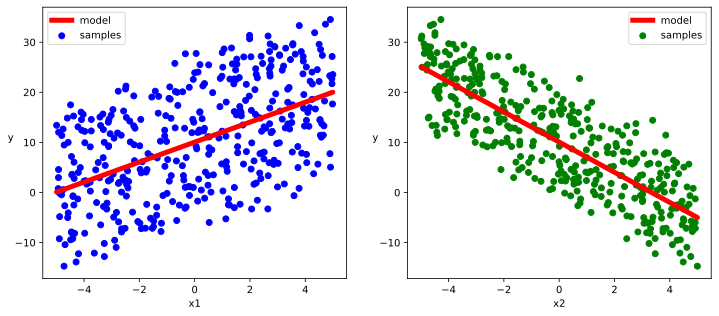

In [8]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.state_dict()["fc.weight"],model.state_dict()["fc.bias"]

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


**4，评估模型**

In [ ]:
dfhistory.tail()

![](./data/3-3-dfhistory.png)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

In [ ]:
plot_metric(dfhistory,"loss")

![](./data/3-3-loss曲线.png)

In [ ]:
plot_metric(dfhistory,"mape")

![](./data/3-3-mape曲线.png)

In [ ]:
# 评估
model.evaluate(dl_valid)

```
{'val_loss': 3.749117374420166,
 'val_mae': 1.5336137612660725,
 'val_mape': 0.36319838215907413}
```

**5，使用模型**

In [ ]:
# 预测
dl = DataLoader(TensorDataset(X))
model.predict(dl)[0:10]

```
tensor([[ 3.9212],
        [ 8.6336],
        [ 6.1982],
        [ 6.1212],
        [-5.0974],
        [-6.3183],
        [ 4.6588],
        [ 5.5349],
        [11.9106],
        [24.6937]])
```

In [ ]:
# 预测
model.predict(dl_valid)[0:10]

```
tensor([[ 2.8368],
        [16.2797],
        [ 2.3135],
        [ 9.5395],
        [16.4363],
        [10.0742],
        [15.0864],
        [12.9775],
        [21.8568],
        [21.8226]])
```

### 二，DNN二分类模型

此范例我们通过继承torchkeras.LightModel模型接口，实现DNN二分类模型。


**1，准备数据**

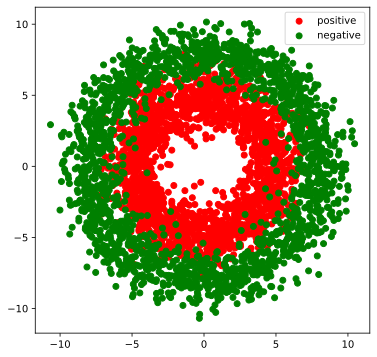

In [9]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchkeras 
import pytorch_lightning as pl 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


![](./data/3-3-分类数据可视化.png)

In [10]:
ds = TensorDataset(X,Y)

ds_train,ds_valid = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 100,num_workers=2)


**2，定义模型**

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
        
class Model(torchkeras.LightModel):
    
    #loss,and optional metrics
    def shared_step(self,batch)->dict:
        x, y = batch
        prediction = self(x)
        loss = nn.BCELoss()(prediction,y)
        preds = torch.where(prediction>0.5,torch.ones_like(prediction),torch.zeros_like(prediction))
        acc = pl.metrics.functional.accuracy(preds, y)
        # attention: there must be a key of "loss" in the returned dict 
        dic = {"loss":loss,"acc":acc} 
        return dic
    
    #optimizer,and optional lr_scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)
        return {"optimizer":optimizer,"lr_scheduler":lr_scheduler}
    
pl.seed_everything(1234)
net = Net()
model = Model(net)


torchkeras.summary(model,input_shape =(2,))



Global seed set to 1234


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------


```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1                    [-1, 4]              12
            Linear-2                    [-1, 8]              40
            Linear-3                    [-1, 1]               9
================================================================
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000008
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000340
----------------------------------------------------------------
```

**3，训练模型**

In [13]:
ckpt_cb = pl.callbacks.ModelCheckpoint(monitor='val_loss')

# set gpus=0 will use cpu，
# set gpus=1 will use 1 gpu
# set gpus=2 will use 2gpus 
# set gpus = -1 will use all gpus 
# you can also set gpus = [0,1] to use the  given gpus
# you can even set tpu_cores=2 to use two tpus 

trainer = pl.Trainer(max_epochs=100,gpus = 0, callbacks=[ckpt_cb]) 

trainer.fit(model,dl_train,dl_valid)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name | Type | Params
------------------------------
0 | net  | Net  | 61    
------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


AttributeError: module 'pytorch_lightning.metrics' has no attribute 'functional'

```
================================================================================2021-01-16 23:41:38
epoch =  0
{'val_loss': 0.6706896424293518, 'val_acc': 0.5558333396911621}
{'acc': 0.5157142281532288, 'loss': 0.6820458769798279}

================================================================================2021-01-16 23:41:39
epoch =  1
{'val_loss': 0.653035581111908, 'val_acc': 0.5708333849906921}
{'acc': 0.5457143783569336, 'loss': 0.6677185297012329}

================================================================================2021-01-16 23:41:40
epoch =  2
{'val_loss': 0.6122683882713318, 'val_acc': 0.6533333659172058}
{'acc': 0.6132143139839172, 'loss': 0.6375874876976013}

================================================================================2021-01-16 23:41:40
epoch =  3
{'val_loss': 0.5168119668960571, 'val_acc': 0.7708333134651184}
{'acc': 0.6842857003211975, 'loss': 0.574131190776825}

================================================================================2021-01-16 23:41:41
epoch =  4
{'val_loss': 0.3789764940738678, 'val_acc': 0.8766666054725647}
{'acc': 0.7900000214576721, 'loss': 0.4608381390571594}

================================================================================2021-01-16 23:41:41
epoch =  5
{'val_loss': 0.2496153712272644, 'val_acc': 0.9208332896232605}
{'acc': 0.8982142806053162, 'loss': 0.3223666250705719}

================================================================================2021-01-16 23:41:42
epoch =  6
{'val_loss': 0.21876734495162964, 'val_acc': 0.9124999642372131}
{'acc': 0.908214271068573, 'loss': 0.24333418905735016}

================================================================================2021-01-16 23:41:43
epoch =  7
{'val_loss': 0.19420616328716278, 'val_acc': 0.9266666769981384}
{'acc': 0.9132143259048462, 'loss': 0.2207658737897873}

================================================================================2021-01-16 23:41:44
epoch =  8
{'val_loss': 0.1835813671350479, 'val_acc': 0.9225000739097595}
{'acc': 0.9185715317726135, 'loss': 0.20826208591461182}

================================================================================2021-01-16 23:41:45
epoch =  9
{'val_loss': 0.17465434968471527, 'val_acc': 0.9300000071525574}
{'acc': 0.9189285039901733, 'loss': 0.20436131954193115}
```


In [ ]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


![](./data/3-3-分类结果可视化.png)

**4，评估模型**

In [ ]:
import pandas as pd 

history = model.history
dfhistory = pd.DataFrame(history) 
dfhistory 

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
plot_metric(dfhistory,"loss")

![](./data/3-3-分类loss曲线.png)

In [ ]:
plot_metric(dfhistory,"acc")

![](./data/3-3-分类acc曲线.png)

In [ ]:
results = trainer.test(model, test_dataloaders=dl_valid, verbose = False)
print(results[0])

```
{'test_loss': 0.18403057754039764, 'test_acc': 0.949999988079071}
```

**5，使用模型**

In [ ]:
def predict(model,dl):
    model.eval()
    prediction = torch.cat([model.forward(t[0].to(model.device)) for t in dl])
    result = torch.where(prediction>0.5,torch.ones_like(prediction),torch.zeros_like(prediction))
    return(result.data)

result = predict(model,dl_valid)

result 

```
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

```

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](./data/算法美食屋二维码.jpg)